# Обучение модели ai-forever/ruRoberta-large для multi-label классификации

In [1]:
!pip install pandas scikit-learn transformers optuna scikit-multilearn openpyxl matplotlib -q 

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_recall_curve, roc_curve, auc, classification_report
from skmultilearn.model_selection import iterative_train_test_split
import joblib
import transformers
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
import json
import math
import gc

# Проверка версий библиотек
print("transformers version:", transformers.__version__)
print("NumPy version:", np.__version__)
print("Optuna version:", optuna.__version__)
print("Matplotlib version:", matplotlib.__version__)  


transformers version: 4.51.3
NumPy version: 1.23.5
Optuna version: 4.3.0
Matplotlib version: 3.10.1


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

In [4]:
# Загрузка датасета
data_path = "../data/processed/final.xlsx"
df = pd.read_excel(data_path)

# Посмотрим на первые строки и общую информацию
print("Размер датасета:", df.shape)
df.head(5)


Размер датасета: (4984, 9)


,Unnamed: 0,full_text,Спорт,Личная жизнь,Юмор,Соцсети,Политика,Реклама,Нет категории
0,614,лебединая песня… (с подтекстом) 2024 год - го...,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,789,ура конкурс!!!!!!! одарим же!!! всех любимых ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,628,"славянский зодиак для познания себе, если еще...",0.0,0.0,0.0,0.5,0.0,0.5,0.0
3,531,английским газетам тяжело даётся ожидание фина...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,347,"итак, самое главное:) по фактам! по минутам, с...",1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Определяем список тематик (берем из колонок кроме full_text)
all_columns = list(df.columns)
label_cols = [col for col in all_columns if col not in ('full_text', 'Unnamed: 0')]
print("Колонки тем:", label_cols)
num_topics = len(label_cols)
print("Количество тем:", num_topics)


Колонки тем: ['Спорт', 'Личная жизнь', 'Юмор', 'Соцсети', 'Политика', 'Реклама', 'Нет категории']
Количество тем: 7


In [6]:
# Преобразуем вероятности в 0/1 при пороге 0.5
threshold = 0.5
df_labels = (df[label_cols] >= threshold).astype(int)

# Добавим бинарные метки к таблице (для ясности, необязательно)
for col in label_cols:
    df[f"{col}_label"] = df_labels[col]

# Посмотрим фрагмент обновленных данных
df.head(5)


,Unnamed: 0,full_text,Спорт,Личная жизнь,Юмор,Соцсети,Политика,Реклама,Нет категории,Спорт_label,Личная жизнь_label,Юмор_label,Соцсети_label,Политика_label,Реклама_label,Нет категории_label
0,614,лебединая песня… (с подтекстом) 2024 год - го...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0
1,789,ура конкурс!!!!!!! одарим же!!! всех любимых ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0
2,628,"славянский зодиак для познания себе, если еще...",0.0,0.0,0.0,0.5,0.0,0.5,0.0,0,0,0,1,0,1,0
3,531,английским газетам тяжело даётся ожидание фина...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
4,347,"итак, самое главное:) по фактам! по минутам, с...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0


In [7]:
# Количество текстов, содержащих каждую тему (частота меток)
label_counts = df_labels.sum()
print("Число текстов по темам:")
print(label_counts)

# Среднее и распределение числа тем на текст
labels_per_text = df_labels.sum(axis=1)
print("\nРаспределение числа меток на текст:")
print(labels_per_text.value_counts(), "\nСреднее:", labels_per_text.mean())


Число текстов по темам:
Спорт            1590
Личная жизнь      743
Юмор              892
Соцсети          1345
Политика          573
Реклама           571
Нет категории     593
dtype: int64

Распределение числа меток на текст:
1    3611
2    1348
0      25
Name: count, dtype: int64 
Среднее: 1.2654494382022472


In [8]:
# Преобразуем данные для разделения
X = df['full_text'].values.reshape(-1, 1)   
Y = df_labels.values                        

# Выполняем стратифицированное разделение на train/val
test_size = 0.2
X_train, y_train, X_val, y_val = iterative_train_test_split(X, Y, test_size=test_size)

# Преобразуем обратно в списки/таблицы
train_texts = X_train.ravel()   # превращаем (n,1) обратно в (n,)
val_texts = X_val.ravel()
train_labels = y_train
val_labels = y_val

print(f"Обучающая выборка: {len(train_texts)} текстов")
print(f"Валидационная выборка: {len(val_texts)} текстов")


Обучающая выборка: 3987 текстов
Валидационная выборка: 997 текстов


In [9]:
train_label_freq = train_labels.mean(axis=0)
val_label_freq = val_labels.mean(axis=0)
freq_df = pd.DataFrame({'train_frac': train_label_freq, 'val_frac': val_label_freq}, index=label_cols)
print("Доля положительных примеров по темам в выборках:")
print(freq_df)


Доля положительных примеров по темам в выборках:
               train_frac  val_frac
Спорт            0.319037  0.318957
Личная жизнь     0.148984  0.149448
Юмор             0.179082  0.178536
Соцсети          0.269877  0.269809
Политика         0.114873  0.115346
Реклама          0.114623  0.114343
Нет категории    0.118886  0.119358


In [10]:
model_name = "ai-forever/ruRoberta-large"
#model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [11]:
num_labels = num_topics  # количество тем
# Создаем сопоставление индексов и названий тем
id2label = {i: label for i, label in enumerate(label_cols)}
label2id = {label: i for i, label in id2label.items()}

# Загружаем модель для классификации
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)
print("Модель загружена. Число классов:", model.config.num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель загружена. Число классов: 7


In [12]:
print("torch version:", torch.__version__)
print("CUDA доступна:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Имя устройства:", torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Вычислительное устройство:", device)
!nvidia-smi

torch version: 2.5.1
CUDA доступна: True
Имя устройства: NVIDIA GeForce RTX 3080 Ti
Вычислительное устройство: cuda
Sat Apr 26 01:00:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     Off |   00000000:01:00.0 Off |                  N/A |
| 54%   58C    P2             38W /  400W |    1623MiB /  12288MiB |     54%      Default |
|                       

In [13]:
# Токенизация текстов
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(list(val_texts), padding=True, truncation=True, max_length=128)

# Проверим пример токенизации
print(train_texts[0])
print(train_encodings['input_ids'][0][:20], "...", "длина:", len(train_encodings['input_ids'][0]))


лебединая песня… (с подтекстом)  2024 год - год лебедя по зороастрийскому (некоторые считают его арийским) календарю. тотемный гороскоп от предков человечества нам достался в наследство 32-летний календарь. уникальность тотемного календаря заключается в том, что каждый год в нем имеет своего управителя — священное животное, тотем. тотемный календарь начинает действовать вдень весеннего равноденствия - 20-21-23 марта. зороастрийский новый год носит название навруз (новруз, ноурыз…) (в переводе с персидского «новый день»). если вы родились 5 января 1976 года, то смотрите себя 1975 годом. так как год в этом летоисчислении начинается весной. для информации: «наступающий 2024 год пройдет под управлением грациозного, элегантного лебедя. этот год будет связан с духовным объединением людей. пришло время подняться над материальным миром, воспарить! пора понять, что не хлебом единым жив человек. и еще, верность семье будет самым главным достоинством в глазах тотема. если вы обладаете этим даром 

In [14]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.astype(np.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Некоторые токенизаторы не выдают token_type_ids для моделей типа RoBERTa, поэтому проверим
        if 'token_type_ids' in item and item['token_type_ids'].ndim == 1:
            # Делаем token_type_ids того же измерения, что и input_ids
            item['token_type_ids'] = item['token_type_ids'].unsqueeze(0)
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Создаем объекты Dataset
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

print("Пример батча:")
for i in range(2):
    example = train_dataset[i]
    print(tokenizer.decode(example['input_ids']), "-- метки:", example['labels'].numpy())


Пример батча:
<s>лебединая песня… (с подтекстом)  2024 год - год лебедя по зороастрийскому (некоторые считают его арийским) календарю. тотемный гороскоп от предков человечества нам достался в наследство 32-летний календарь. уникальность тотемного календаря заключается в том, что каждый год в нем имеет своего управителя — священное животное, тотем. тотемный календарь начинает действовать вдень весеннего равноденствия - 20-21-23 марта. зороастрийский новый год носит название навруз (новруз, ноурыз…) (в переводе с</s> -- метки: [0. 0. 0. 0. 0. 1. 0.]
<s>славянский зодиак  для познания себе, если еще мозг не закипел, ознакомьтесь с собой по дням и месяцам славянского зодиака. каждому месяцу в году и дате рождения соответствовало определенное животное. считалось, что люди, рожденные в этом месяце, обладали качествами этого животного. тотемы животных влияли на судьбу человека. таких животных 12, хотя есть предположение, что первоначально их было больше. самый древний славянский животный горо

In [15]:

def objective(trial):
    gc.collect()
    torch.cuda.empty_cache()
    # Выбираем значения гиперпараметров из заданных диапазонов
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    #batch_size = trial.suggest_categorical('batch_size', [4, 8])
    batch_size = trial.suggest_categorical('batch_size', [8, 16])
    num_epochs = trial.suggest_int('num_epochs', 3, 6)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)
    
    # Инициализируем новую модель с исходными (pretrained) весами для данного trial
    model_trial = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=num_labels, 
        problem_type="multi_label_classification",
        id2label=id2label,
        label2id=label2id
    )
    model_trial.to(device)
    
    # Параметры обучения
    args = TrainingArguments(
        output_dir="optuna_trial",       # временная директория для вывода (можно переиспользовать)
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        metric_for_best_model="f1_micro",
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        # Отключаем сохранения и подробный лог
        save_strategy="no",
        logging_strategy="no",
        # Отключаем прогресс-бар для ускорения вывода
        disable_tqdm=True,
        # Используем GPU и смешанную точность
        dataloader_pin_memory=True,
        fp16=True,
        seed=SEED
    )
    
    # Создаем Trainer
    trainer = Trainer(
        model=model_trial,
        args=args,
        train_dataset=train_dataset,
        # Оценку на валидации проведём вручную после обучения
        # (чтобы сэкономить время, не делаем eval на каждой эпохе)
    )
    
    # Обучаем модель
    trainer.train()
    
    # Предсказываем на валидации
    preds = trainer.predict(val_dataset)
    logits = preds.predictions  # логиты модели (до применения сигмоиды)
    # Применяем сигмоиду к логитам для получения вероятностей
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    # Бинаризуем по порогу 0.5
    y_pred = (probs >= 0.5).astype(int)
    y_true = preds.label_ids
    
    # Вычисляем micro F1 как целевую метрику
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    # Опционально: очищаем GPU память (если большие модели, чтобы не накапливались)
    torch.cuda.empty_cache()
    
    # Возвращаем значение, которое хотим **максимизировать**
    return f1_micro

In [16]:
# Создаем исследование Optuna
study = optuna.create_study(direction='maximize', study_name="Multilabel_Optimization")
# Запускаем поиск (например, 5 итераций для демонстрации; можно увеличить для более точного подбора)
study.optimize(objective, n_trials=50)

print("Наилучшее значение F1 (micro) на валидации: {:.4f}".format(study.best_value))
print("Лучшие гиперпараметры:", study.best_params)


[I 2025-04-26 01:00:30,834] A new study created in memory with name: Multilabel_Optimization
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.6577, 'train_samples_per_second': 113.382, 'train_steps_per_second': 7.109, 'train_loss': 0.19872074890136718, 'epoch': 4.0}


[I 2025-04-26 01:02:54,969] Trial 0 finished with value: 0.7398843930635838 and parameters: {'learning_rate': 1.2304128107990588e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.07215303721456083}. Best is trial 0 with value: 0.7398843930635838.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 152.3463, 'train_samples_per_second': 78.512, 'train_steps_per_second': 9.826, 'train_loss': 0.211699909421708, 'epoch': 3.0}


[I 2025-04-26 01:05:31,134] Trial 1 finished with value: 0.7372845733501471 and parameters: {'learning_rate': 1.1450257833804287e-05, 'batch_size': 8, 'num_epochs': 3, 'weight_decay': 0.042433350434230924}. Best is trial 0 with value: 0.7398843930635838.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 254.212, 'train_samples_per_second': 78.419, 'train_steps_per_second': 9.815, 'train_loss': 0.15491681605398297, 'epoch': 5.0}


[I 2025-04-26 01:09:49,161] Trial 2 finished with value: 0.7485943775100402 and parameters: {'learning_rate': 1.3413602821479271e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.047921093421331155}. Best is trial 2 with value: 0.7485943775100402.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 176.408, 'train_samples_per_second': 113.005, 'train_steps_per_second': 7.086, 'train_loss': 0.17704017333984376, 'epoch': 5.0}


[I 2025-04-26 01:12:49,212] Trial 3 finished with value: 0.7495934959349594 and parameters: {'learning_rate': 1.5102008389668126e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.09960246291696269}. Best is trial 3 with value: 0.7495934959349594.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 176.4545, 'train_samples_per_second': 112.975, 'train_steps_per_second': 7.084, 'train_loss': 0.180765185546875, 'epoch': 5.0}


[I 2025-04-26 01:15:49,163] Trial 4 finished with value: 0.7438825448613376 and parameters: {'learning_rate': 1.3166490646311549e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.09570246618025373}. Best is trial 3 with value: 0.7495934959349594.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 254.4282, 'train_samples_per_second': 78.352, 'train_steps_per_second': 9.806, 'train_loss': 0.23191651858404308, 'epoch': 5.0}


[I 2025-04-26 01:20:07,392] Trial 5 finished with value: 0.7343812978637646 and parameters: {'learning_rate': 1.5995417670284892e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.07605177265500952}. Best is trial 3 with value: 0.7495934959349594.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 254.3851, 'train_samples_per_second': 78.365, 'train_steps_per_second': 9.808, 'train_loss': 0.45716144202467435, 'epoch': 5.0}


[I 2025-04-26 01:24:25,673] Trial 6 finished with value: 0.0 and parameters: {'learning_rate': 4.839847340299642e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.06604438550041754}. Best is trial 3 with value: 0.7495934959349594.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 176.4986, 'train_samples_per_second': 112.947, 'train_steps_per_second': 7.082, 'train_loss': 0.16686629638671874, 'epoch': 5.0}


[I 2025-04-26 01:27:25,817] Trial 7 finished with value: 0.748471259682022 and parameters: {'learning_rate': 1.5534719330127856e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.0008951724521892746}. Best is trial 3 with value: 0.7495934959349594.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 152.6058, 'train_samples_per_second': 78.378, 'train_steps_per_second': 9.81, 'train_loss': 0.22343788325348615, 'epoch': 3.0}


[I 2025-04-26 01:30:02,194] Trial 8 finished with value: 0.7463414634146341 and parameters: {'learning_rate': 2.119477056236117e-05, 'batch_size': 8, 'num_epochs': 3, 'weight_decay': 0.021977526952828532}. Best is trial 3 with value: 0.7495934959349594.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 105.8256, 'train_samples_per_second': 113.026, 'train_steps_per_second': 7.087, 'train_loss': 0.232826904296875, 'epoch': 3.0}


[I 2025-04-26 01:31:51,510] Trial 9 finished with value: 0.7332200509770603 and parameters: {'learning_rate': 1.3488455419712117e-05, 'batch_size': 16, 'num_epochs': 3, 'weight_decay': 0.07471463131020344}. Best is trial 3 with value: 0.7495934959349594.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.9014, 'train_samples_per_second': 112.892, 'train_steps_per_second': 7.079, 'train_loss': 0.19657210286458332, 'epoch': 6.0}


[I 2025-04-26 01:35:27,227] Trial 10 finished with value: 0.7411811335711455 and parameters: {'learning_rate': 3.661714808665781e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.0997574702852958}. Best is trial 3 with value: 0.7495934959349594.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 305.2536, 'train_samples_per_second': 78.368, 'train_steps_per_second': 9.808, 'train_loss': 0.13728464008094313, 'epoch': 6.0}


[I 2025-04-26 01:40:36,259] Trial 11 finished with value: 0.7454191033138402 and parameters: {'learning_rate': 2.170813731312653e-05, 'batch_size': 8, 'num_epochs': 6, 'weight_decay': 0.035258999709319026}. Best is trial 3 with value: 0.7495934959349594.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 203.5944, 'train_samples_per_second': 78.332, 'train_steps_per_second': 9.804, 'train_loss': 0.1829376220703125, 'epoch': 4.0}


[I 2025-04-26 01:44:08,685] Trial 12 finished with value: 0.7544220485396956 and parameters: {'learning_rate': 1.0203909635505166e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.056152175742299824}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 141.2532, 'train_samples_per_second': 112.904, 'train_steps_per_second': 7.079, 'train_loss': 0.21196728515625, 'epoch': 4.0}


[I 2025-04-26 01:46:33,402] Trial 13 finished with value: 0.738655462184874 and parameters: {'learning_rate': 1.0134094005148714e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.06058347321046554}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.676, 'train_samples_per_second': 78.687, 'train_steps_per_second': 9.848, 'train_loss': 0.17221188593006326, 'epoch': 4.0}


[I 2025-04-26 01:49:59,847] Trial 14 finished with value: 0.739413680781759 and parameters: {'learning_rate': 1.795632878074505e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.08832870185302977}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 141.0309, 'train_samples_per_second': 113.082, 'train_steps_per_second': 7.091, 'train_loss': 0.17477369689941405, 'epoch': 4.0}


[I 2025-04-26 01:52:24,460] Trial 15 finished with value: 0.7463651050080775 and parameters: {'learning_rate': 2.650772821666533e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.02468688463580712}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 305.111, 'train_samples_per_second': 78.404, 'train_steps_per_second': 9.813, 'train_loss': 0.1447949202441341, 'epoch': 6.0}


[I 2025-04-26 01:57:33,337] Trial 16 finished with value: 0.7457351746547523 and parameters: {'learning_rate': 1.0058439360963965e-05, 'batch_size': 8, 'num_epochs': 6, 'weight_decay': 0.0849293110536856}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.9515, 'train_samples_per_second': 113.145, 'train_steps_per_second': 7.095, 'train_loss': 0.19065545654296875, 'epoch': 4.0}


[I 2025-04-26 01:59:58,221] Trial 17 finished with value: 0.7455670103092783 and parameters: {'learning_rate': 1.8063211823956324e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.05795501628241772}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.8623, 'train_samples_per_second': 78.615, 'train_steps_per_second': 9.839, 'train_loss': 0.1792250119134754, 'epoch': 4.0}


[I 2025-04-26 02:03:24,841] Trial 18 finished with value: 0.7437348423605498 and parameters: {'learning_rate': 2.723938719298603e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.016315970085072795}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 176.0492, 'train_samples_per_second': 113.235, 'train_steps_per_second': 7.1, 'train_loss': 0.1708859130859375, 'epoch': 5.0}


[I 2025-04-26 02:06:24,376] Trial 19 finished with value: 0.7444717444717445 and parameters: {'learning_rate': 1.56530786881372e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.03654188954252794}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.3072, 'train_samples_per_second': 113.21, 'train_steps_per_second': 7.099, 'train_loss': 0.16257249959309897, 'epoch': 6.0}


[I 2025-04-26 02:09:59,330] Trial 20 finished with value: 0.7406807131280388 and parameters: {'learning_rate': 1.1073460370295439e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.053887278782181386}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.7195, 'train_samples_per_second': 78.571, 'train_steps_per_second': 9.834, 'train_loss': 0.1519375787708229, 'epoch': 5.0}


[I 2025-04-26 02:14:16,987] Trial 21 finished with value: 0.7487961476725522 and parameters: {'learning_rate': 1.316872205745892e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.04515967953429449}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.6465, 'train_samples_per_second': 78.594, 'train_steps_per_second': 9.837, 'train_loss': 0.15983458616451654, 'epoch': 5.0}


[I 2025-04-26 02:18:34,684] Trial 22 finished with value: 0.7541899441340782 and parameters: {'learning_rate': 1.4131035803778464e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.0463146669503529}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.7953, 'train_samples_per_second': 78.548, 'train_steps_per_second': 9.831, 'train_loss': 0.45800203923471944, 'epoch': 5.0}


[I 2025-04-26 02:22:52,704] Trial 23 finished with value: 0.0 and parameters: {'learning_rate': 1.754179837031496e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.03190887712797187}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.9055, 'train_samples_per_second': 78.598, 'train_steps_per_second': 9.837, 'train_loss': 0.4587097779543462, 'epoch': 4.0}


[I 2025-04-26 02:26:19,517] Trial 24 finished with value: 0.001583531274742676 and parameters: {'learning_rate': 1.5103857411135597e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.06498354459431792}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.6603, 'train_samples_per_second': 78.589, 'train_steps_per_second': 9.836, 'train_loss': 0.15819663007655937, 'epoch': 5.0}


[I 2025-04-26 02:30:36,940] Trial 25 finished with value: 0.7444128403088176 and parameters: {'learning_rate': 1.159968468713425e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.08792130896834452}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 304.3947, 'train_samples_per_second': 78.589, 'train_steps_per_second': 9.836, 'train_loss': 0.16511145256006804, 'epoch': 6.0}


[I 2025-04-26 02:35:45,565] Trial 26 finished with value: 0.7435090479937058 and parameters: {'learning_rate': 2.7106026071568963e-05, 'batch_size': 8, 'num_epochs': 6, 'weight_decay': 0.010648872037567605}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.8404, 'train_samples_per_second': 78.623, 'train_steps_per_second': 9.84, 'train_loss': 0.171614729091973, 'epoch': 4.0}


[I 2025-04-26 02:39:12,389] Trial 27 finished with value: 0.7512155591572123 and parameters: {'learning_rate': 1.8875732545067847e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.07994344210696089}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 152.0669, 'train_samples_per_second': 78.656, 'train_steps_per_second': 9.844, 'train_loss': 0.19917143450312083, 'epoch': 3.0}


[I 2025-04-26 02:41:48,221] Trial 28 finished with value: 0.7324058919803601 and parameters: {'learning_rate': 1.9562541004213216e-05, 'batch_size': 8, 'num_epochs': 3, 'weight_decay': 0.052303051081882164}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.747, 'train_samples_per_second': 78.66, 'train_steps_per_second': 9.845, 'train_loss': 0.17263512620945015, 'epoch': 4.0}


[I 2025-04-26 02:45:14,908] Trial 29 finished with value: 0.7480792559644157 and parameters: {'learning_rate': 2.302691998130363e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.07968610567101617}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 151.7842, 'train_samples_per_second': 78.803, 'train_steps_per_second': 9.863, 'train_loss': 0.21260711934937584, 'epoch': 3.0}


[I 2025-04-26 02:47:50,633] Trial 30 finished with value: 0.734642707898036 and parameters: {'learning_rate': 1.2219240970235342e-05, 'batch_size': 8, 'num_epochs': 3, 'weight_decay': 0.06663985162393751}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.34, 'train_samples_per_second': 78.818, 'train_steps_per_second': 9.865, 'train_loss': 0.17623884548882923, 'epoch': 4.0}


[I 2025-04-26 02:51:16,936] Trial 31 finished with value: 0.7493857493857494 and parameters: {'learning_rate': 1.4296490387809717e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.09358055125788083}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.5733, 'train_samples_per_second': 113.45, 'train_steps_per_second': 7.114, 'train_loss': 0.18864616394042968, 'epoch': 4.0}


[I 2025-04-26 02:53:41,137] Trial 32 finished with value: 0.7444352844187964 and parameters: {'learning_rate': 2.447274630890605e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.07939016666865077}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.4234, 'train_samples_per_second': 78.663, 'train_steps_per_second': 9.845, 'train_loss': 0.1505707092896731, 'epoch': 5.0}


[I 2025-04-26 02:57:58,293] Trial 33 finished with value: 0.7486932046642542 and parameters: {'learning_rate': 1.685912519464417e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.07063052856780097}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.1062, 'train_samples_per_second': 78.761, 'train_steps_per_second': 9.858, 'train_loss': 0.3889553276474825, 'epoch': 5.0}


[I 2025-04-26 03:02:15,670] Trial 34 finished with value: 0.4108433734939759 and parameters: {'learning_rate': 1.9757736710422427e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.09264432815388797}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.0236, 'train_samples_per_second': 78.787, 'train_steps_per_second': 9.861, 'train_loss': 0.15636992980100828, 'epoch': 5.0}


[I 2025-04-26 03:06:32,828] Trial 35 finished with value: 0.7523083099156965 and parameters: {'learning_rate': 1.4317106783764486e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.04071214542770918}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.6278, 'train_samples_per_second': 78.706, 'train_steps_per_second': 9.851, 'train_loss': 0.19014189572993642, 'epoch': 4.0}


[I 2025-04-26 03:09:59,340] Trial 36 finished with value: 0.7508223684210527 and parameters: {'learning_rate': 1.1068460019553816e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.04379718878698455}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.2934, 'train_samples_per_second': 78.703, 'train_steps_per_second': 9.85, 'train_loss': 0.15686722566226202, 'epoch': 5.0}


[I 2025-04-26 03:14:16,428] Trial 37 finished with value: 0.7512155591572123 and parameters: {'learning_rate': 1.246049924666818e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.03925428712426515}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.2271, 'train_samples_per_second': 78.724, 'train_steps_per_second': 9.853, 'train_loss': 0.15890955494974324, 'epoch': 5.0}


[I 2025-04-26 03:18:33,587] Trial 38 finished with value: 0.7386454183266933 and parameters: {'learning_rate': 1.415466422596588e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.05038004654866078}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 151.8171, 'train_samples_per_second': 78.786, 'train_steps_per_second': 9.861, 'train_loss': 0.25034621244442007, 'epoch': 3.0}


[I 2025-04-26 03:21:09,287] Trial 39 finished with value: 0.740710494079216 and parameters: {'learning_rate': 1.921402600948973e-05, 'batch_size': 8, 'num_epochs': 3, 'weight_decay': 0.05824473515757957}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.6287, 'train_samples_per_second': 78.706, 'train_steps_per_second': 9.851, 'train_loss': 0.17367755530592435, 'epoch': 4.0}


[I 2025-04-26 03:24:35,673] Trial 40 finished with value: 0.7502040816326531 and parameters: {'learning_rate': 1.6618085961026802e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.03147949300544243}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.4173, 'train_samples_per_second': 78.665, 'train_steps_per_second': 9.845, 'train_loss': 0.15468465006184243, 'epoch': 5.0}


[I 2025-04-26 03:28:52,846] Trial 41 finished with value: 0.7467532467532467 and parameters: {'learning_rate': 1.252853391279765e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.03890202712869363}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.396, 'train_samples_per_second': 78.671, 'train_steps_per_second': 9.846, 'train_loss': 0.17526316059854083, 'epoch': 5.0}


[I 2025-04-26 03:33:10,365] Trial 42 finished with value: 0.7447495961227787 and parameters: {'learning_rate': 1.166322682095623e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.04067697279728144}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.4071, 'train_samples_per_second': 78.668, 'train_steps_per_second': 9.846, 'train_loss': 0.45842343867422347, 'epoch': 5.0}


[I 2025-04-26 03:37:27,727] Trial 43 finished with value: 0.001583531274742676 and parameters: {'learning_rate': 1.4168265365251587e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.047623145918480825}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.4369, 'train_samples_per_second': 78.659, 'train_steps_per_second': 9.845, 'train_loss': 0.15579753256513026, 'epoch': 5.0}


[I 2025-04-26 03:41:45,104] Trial 44 finished with value: 0.7467948717948718 and parameters: {'learning_rate': 1.2548585147000384e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.028848429418325057}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.4393, 'train_samples_per_second': 78.779, 'train_steps_per_second': 9.86, 'train_loss': 0.2121341376600858, 'epoch': 4.0}


[I 2025-04-26 03:45:11,567] Trial 45 finished with value: 0.7444352844187964 and parameters: {'learning_rate': 1.0661790678127289e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.04357779421488683}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.3406, 'train_samples_per_second': 78.689, 'train_steps_per_second': 9.848, 'train_loss': 0.15656688132123622, 'epoch': 5.0}


[I 2025-04-26 03:49:28,717] Trial 46 finished with value: 0.7502027575020276 and parameters: {'learning_rate': 1.2129093006306214e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.022994473960092972}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 304.0298, 'train_samples_per_second': 78.683, 'train_steps_per_second': 9.848, 'train_loss': 0.1357659879492057, 'epoch': 6.0}


[I 2025-04-26 03:54:36,916] Trial 47 finished with value: 0.7502977371973005 and parameters: {'learning_rate': 1.35063997312784e-05, 'batch_size': 8, 'num_epochs': 6, 'weight_decay': 0.055048088537680465}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.2843, 'train_samples_per_second': 78.706, 'train_steps_per_second': 9.851, 'train_loss': 0.16603257785101452, 'epoch': 5.0}


[I 2025-04-26 03:58:54,142] Trial 48 finished with value: 0.7471309853581322 and parameters: {'learning_rate': 3.053949966980782e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.06186210596530228}. Best is trial 12 with value: 0.7544220485396956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.63, 'train_samples_per_second': 78.705, 'train_steps_per_second': 9.85, 'train_loss': 0.19717628922395572, 'epoch': 4.0}


[I 2025-04-26 04:02:20,770] Trial 49 finished with value: 0.737577002053388 and parameters: {'learning_rate': 1.0610022291623612e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.03563054720127319}. Best is trial 12 with value: 0.7544220485396956.


Наилучшее значение F1 (micro) на валидации: 0.7544
Лучшие гиперпараметры: {'learning_rate': 1.0203909635505166e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.056152175742299824}


In [17]:
# Сохраняем объект Optuna study в файл
joblib.dump(study, "../configs/optuna_study.pkl")

# Сохраняем лучшие гиперпараметры в JSON
best_params = study.best_params
best_params['best_val_microF1'] = study.best_value
with open("../configs/best_hyperparams.json", "w") as f:
    #import json
    json.dump(best_params, f, indent=4)


In [18]:
# Извлекаем лучшие гиперпараметры
best_params = study.best_params
best_batch_size = best_params['batch_size']
best_lr = best_params['learning_rate']
best_epochs = best_params['num_epochs']
best_wd = best_params['weight_decay']

# Инициализируем модель с нуля (предобученные веса)
final_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)
final_model.to(device)

# Настраиваем аргументы обучения
training_args = TrainingArguments(
    output_dir="../models/final_model",
    per_device_train_batch_size=best_batch_size,
    per_device_eval_batch_size=best_batch_size,
    learning_rate=best_lr,
    num_train_epochs=best_epochs,
    weight_decay=best_wd,
    logging_strategy="epoch",
    eval_strategy="no",   # Обновлено
    save_strategy="no",   # Обновлено
    fp16=True,
    seed=SEED
)

trainer_final = Trainer(
    model=final_model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=val_dataset,  # можем указать для мониторинга, но финальную оценку сделаем отдельно
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
trainer_final.train()


Step,Training Loss
499,0.307400
998,0.196800
1497,0.139800
1996,0.103300


TrainOutput(global_step=1996, training_loss=0.18684685349703312, metrics={'train_runtime': 202.9567, 'train_samples_per_second': 78.578, 'train_steps_per_second': 9.835, 'total_flos': 3715673116916736.0, 'train_loss': 0.18684685349703312, 'epoch': 4.0})

In [20]:
# Сохранение обученной модели и токенизатора
trainer_final.model.save_pretrained("../models/final_model")
tokenizer.save_pretrained("../models/final_model")
print("Модель и токенизатор сохранены в ../models/final_model/")

# Внимание, модели могут занимать много места и хранятся отдельно
# https://drive.google.com/drive/folders/1F62--WR0UaHIkDsE0IpWxGPP7_MWRES_?usp=drive_link

Модель и токенизатор сохранены в ../models/final_model/


<h1 style="color:red;">Внимание, модели могут занимать много места и хранятся отдельно</h1>

<p><a href="https://drive.google.com/drive/folders/1F62--WR0UaHIkDsE0IpWxGPP7_MWRES_?usp=drive_link" target="_blank">Ссылка на модели (Google Drive)</a></p>

In [21]:
# Предсказание на валидационной выборке
preds = trainer_final.predict(val_dataset)
logits = preds.predictions
probs = torch.sigmoid(torch.tensor(logits)).numpy()
y_true = preds.label_ids
y_pred_05 = (probs >= 0.5).astype(int)


In [22]:
micro_f1 = f1_score(y_true, y_pred_05, average='micro')
macro_f1 = f1_score(y_true, y_pred_05, average='macro')
macro_roc_auc = roc_auc_score(y_true, probs, average='macro')
accuracy = accuracy_score(y_true, y_pred_05)

print(f"Micro F1 = {micro_f1:.3f}")
print(f"Macro F1 = {macro_f1:.3f}")
print(f"Macro ROC-AUC = {macro_roc_auc:.3f}")
print(f"Subset Accuracy = {accuracy:.3f}")


Micro F1 = 0.745
Macro F1 = 0.709
Macro ROC-AUC = 0.925
Subset Accuracy = 0.586


In [23]:
#from sklearn.metrics import classification_report
topic_report = classification_report(
    y_true, 
    y_pred_05, 
    target_names=label_cols, 
    digits=3, 
    output_dict=False,
    zero_division=0
)
print(topic_report)


               precision    recall  f1-score   support

        Спорт      0.936     0.918     0.927       318
 Личная жизнь      0.706     0.517     0.597       149
         Юмор      0.738     0.758     0.748       178
      Соцсети      0.761     0.617     0.682       269
     Политика      0.807     0.800     0.803       115
      Реклама      0.598     0.667     0.631       114
Нет категории      0.722     0.479     0.576       119

    micro avg      0.784     0.709     0.745      1262
    macro avg      0.753     0.679     0.709      1262
 weighted avg      0.781     0.709     0.739      1262
  samples avg      0.788     0.748     0.749      1262



In [24]:
best_thresholds = {}
for i, topic in enumerate(label_cols):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], probs[:, i])
    # Вычисляем F1 для каждого порога
    f1_scores = []
    for p, r in zip(precision, recall):
        if p + r == 0:
            f1 = 0
        else:
            f1 = 2 * p * r / (p + r)
        f1_scores.append(f1)
    f1_scores = np.array(f1_scores)
    best_idx = f1_scores[:-1].argmax()  # последний элемент precision/recall не имеет соотв. порога
    best_thr = thresholds[best_idx]
    best_thresholds[topic] = best_thr
    print(f"Тема '{topic}': лучший порог = {best_thr:.3f}, F1 = {f1_scores[best_idx]:.3f}")


Тема 'Спорт': лучший порог = 0.214, F1 = 0.939
Тема 'Личная жизнь': лучший порог = 0.194, F1 = 0.625
Тема 'Юмор': лучший порог = 0.720, F1 = 0.777
Тема 'Соцсети': лучший порог = 0.430, F1 = 0.705
Тема 'Политика': лучший порог = 0.477, F1 = 0.814
Тема 'Реклама': лучший порог = 0.700, F1 = 0.645
Тема 'Нет категории': лучший порог = 0.179, F1 = 0.606


In [25]:
# Применяем индивидуальные пороги для каждого класса
y_pred_opt = np.zeros_like(y_pred_05)
for i, topic in enumerate(label_cols):
    thr = best_thresholds[topic]
    y_pred_opt[:, i] = (probs[:, i] >= thr).astype(int)

micro_f1_opt = f1_score(y_true, y_pred_opt, average='micro')
macro_f1_opt = f1_score(y_true, y_pred_opt, average='macro')
accuracy_opt = accuracy_score(y_true, y_pred_opt)
print(f"После калибровки порогов: micro F1 = {micro_f1_opt:.3f}, macro F1 = {macro_f1_opt:.3f}, accuracy = {accuracy_opt:.3f}")


После калибровки порогов: micro F1 = 0.760, macro F1 = 0.730, accuracy = 0.586


In [26]:
# Функция для приведения к сериализуемому виду
def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_serializable(v) for v in obj]
    elif isinstance(obj, np.generic):  # все numpy-скаляры
        return obj.item()
    else:
        return obj

# Подготовка данных
config = {
    "model_name": model_name,
    "best_hyperparams": make_serializable(best_params),
    "thresholds": make_serializable(best_thresholds)
}

# Сохраняем в файл
with open("../configs/final_config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

print("Конфигурация с гиперпараметрами и порогами сохранена в configs/final_config.json ✅")


Конфигурация с гиперпараметрами и порогами сохранена в configs/final_config.json ✅


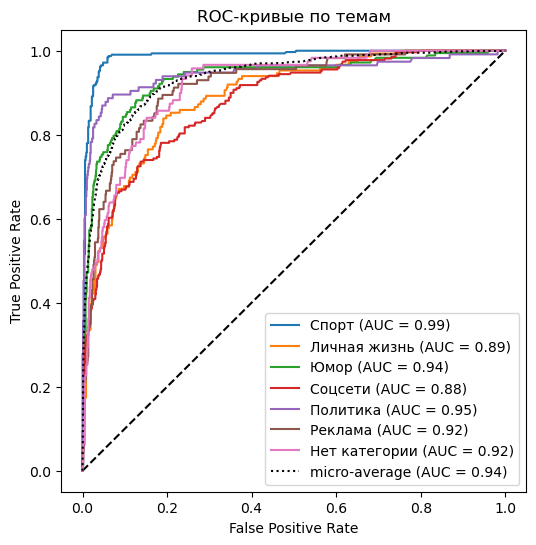

In [27]:
# Вычисляем точки для ROC-кривых
fpr = {}
tpr = {}
roc_auc = {}
for i, topic in enumerate(label_cols):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Микро-усредненная ROC (считаем как если все метки в один длинный список)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Строим график
plt.figure(figsize=(6, 6))
# Диагональ случайного угадывания
plt.plot([0, 1], [0, 1], 'k--')
# Кривые по темам
for i, topic in enumerate(label_cols):
    plt.plot(fpr[i], tpr[i], label=f"{topic} (AUC = {roc_auc[i]:.2f})")
# Микро усредненная кривая
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC = {roc_auc['micro']:.2f})", color='black', linestyle=':')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по темам")
plt.legend(loc="lower right")
plt.show()


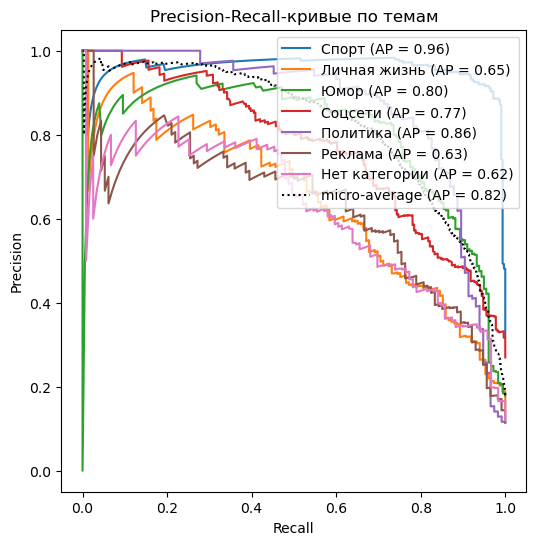

In [28]:
plt.figure(figsize=(6, 6))
for i, topic in enumerate(label_cols):
    precision, recall, _ = precision_recall_curve(y_true[:, i], probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{topic} (AP = {pr_auc:.2f})")
# микро-усредненная PR
precision_micro, recall_micro, _ = precision_recall_curve(y_true.ravel(), probs.ravel())
ap_micro = auc(recall_micro, precision_micro)
plt.plot(recall_micro, precision_micro, label=f"micro-average (AP = {ap_micro:.2f})", color='black', linestyle=':')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-кривые по темам")
plt.legend(loc="upper right")
plt.show()


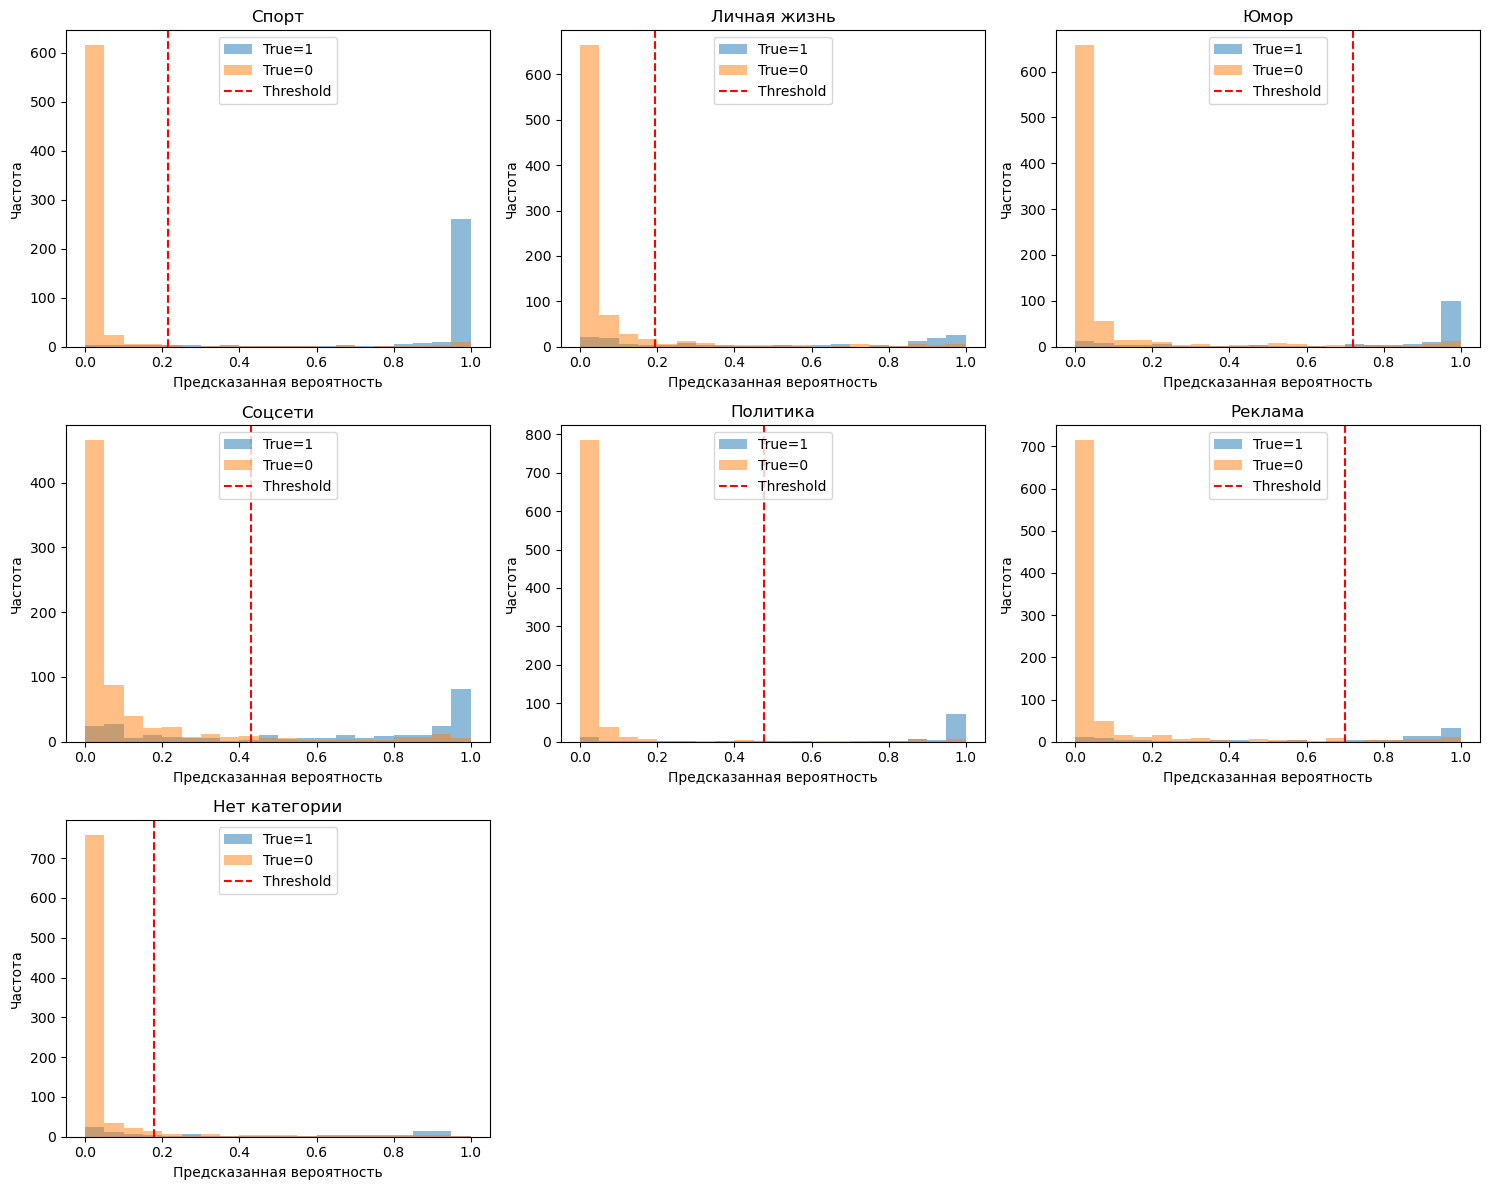

In [29]:
n_labels = len(label_cols)
n_cols = 3
n_rows = math.ceil(n_labels / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(label_cols):
    ax = axes[i]
    pos_probs = probs[y_true[:, i] == 1, i]
    neg_probs = probs[y_true[:, i] == 0, i]
    ax.hist(pos_probs, bins=20, range=(0,1), alpha=0.5, label="True=1")
    ax.hist(neg_probs, bins=20, range=(0,1), alpha=0.5, label="True=0")
    ax.axvline(best_thresholds.get(topic, 0.5), color='red', linestyle='--', label='Threshold')
    ax.set_title(topic)
    ax.set_xlabel("Предсказанная вероятность")
    ax.set_ylabel("Частота")
    ax.legend(loc="upper center")

# Отключим пустые графики если их больше, чем нужно
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

